# Report 3

In [1]:
import pandas as pd
import numpy as np
from distfit import distfit
import scipy.stats as ss
import matplotlib.pyplot as plt

# Chi-Square Function

In [2]:
""" data analysis with chi-square goodness of fit"""

def obs_cts(n, data):
    """ given: the data and number of bins
        returns: the observed values and the bin edges as lists"""
    events, edges = np.histogram(data, n)
    return events.tolist() , edges.tolist()

def exp_cts(n, data):
    """ given: the data and number of bins
        returns: the expected values and prob over each of the bins with
        the necessary modification of the first and last bins"""
    L=[]
    P_bins =[]
    for x in obs_cts(n,data)[1]:
        L.append(rv.cdf(x))
    P_bins.append(L[1])    
    for i in range(1,len(L)-2):
        P_bins.append(L[i+1]-L[i])    
    P_bins.append(1-L[-2])
    exp_cnt = [x * len(data) for x in P_bins]
    return exp_cnt, P_bins

def ind_bins_to_reduce(f_exp):
    """ given: a list
        returns: the indexes of the elements < 5"""
    NC_to_red =[index for index,value in enumerate(f_exp) if value < 5]
    return NC_to_red

def one_reduce(f_exp, f_obs, f_edge):
    """ given: lists of exp, obs, edges
        returns: new lists with one reduced bin with value < 5 """
    BTR = ind_bins_to_reduce(f_exp)
  
    if (len(BTR)>1 or (len(BTR)==1 and BTR[0]!=0)):
        f_exp[BTR[-1]-1] = f_exp[BTR[-1]-1]+f_exp[BTR[-1]]
        f_obs[BTR[-1]-1] = f_obs[BTR[-1]-1]+f_obs[BTR[-1]]
        del(f_edge[BTR[-1]])
        del(f_obs[BTR[-1]])
        del(f_exp[BTR[-1]])
    else:
        if BTR[0]==0:
            f_exp[1]= f_exp[1]+f_exp[0]
            f_obs[1]= f_obs[1]+f_obs[0]
            del(f_edge[1])
            del(f_obs[0])
            del(f_exp[0])

    f_expN = f_exp
    f_obsN = f_obs
    f_edgeN = f_edge
    BTRN = ind_bins_to_reduce(f_expN)
    return f_expN, f_obsN, f_edgeN, BTRN

def all_reduce(f_expF, f_obsF, f_edgeF, BTRF):
    """ finalizes the bin reduction """
    while BTRF !=[]:
        u = one_reduce(f_expF, f_obsF, f_edgeF)
        f_expF = u[0]
        f_obsF = u[1]
        f_edgeF = u[2]
        BTRF = u[3]
    return f_expF, f_obsF, f_edgeF, BTRF


def model(data, n, dof):
        """ given data, the number of bins (n) and the number of estimated parameters (dof)
        produces the value of the chi-squate test statistics and the p-value"""

        ## final expected count and final observed count after amalgamating bins
        exp, obs = all_reduce(exp_cts(n, data)[0],obs_cts(n, data)[0],
                obs_cts(n, data)[1], ind_bins_to_reduce(exp_cts(n, data)[0]))[0:2] 

        # build in chi-gof test, the last argument is the adjustment to the dof
        result = ss.chisquare( np.asarray(obs), np.asarray(exp), dof) 
        return result 

# Arrivals

## Graph Arrivals

In [4]:
data = pd.read_csv("Cafe Louis Data.csv")

In [5]:
data

,Observations,Inter-Arrival Time,Waiting Time,Service Time
0,1,0.00,0.00,51.90
1,2,15.38,43.96,35.75
2,3,68.47,0.00,25.13
3,4,13.09,0.00,33.16
4,5,19.40,11.14,31.19
...,...,...,...,...
246,247,3.85,9.45,38.54
247,248,0.85,44.04,65.76
248,249,10.97,45.04,12.31
249,250,0.59,71.38,102.32


In [6]:
arrivals = data["Inter-Arrival Time"]

dfit = distfit(distr = ['expon','erlang', 'gamma'])

dfit.fit_transform(arrivals)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon ] [0.00 sec] [RSS: 5.27859e-05] [loc=0.000 scale=27.675]
[distfit] >INFO> [erlang] [0.12 sec] [RSS: 0.000840505] [loc=-0.000 scale=672.021]
[distfit] >INFO> [gamma ] [0.10 sec] [RSS: 0.000110435] [loc=-0.000 scale=36.272]
[distfit] >INFO> Compute confidence intervals [parametric]


{'model': {'name': 'expon',
  'score': 5.278591824790488e-05,
  'loc': 0.0,
  'scale': 27.674940239043824,
  'arg': (),
  'params': (0.0, 27.674940239043824),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2830a460390>,
  'bootstrap_score': 0,
  'bootstrap_pass': None,
  'color': '#e41a1c',
  'CII_min_alpha': 1.4195388568391432,
  'CII_max_alpha': 82.90671164278156},
 'summary':      name     score  loc       scale                    arg  \
 0   expon  0.000053  0.0    27.67494                     ()   
 1   gamma   0.00011 -0.0   36.272012  (0.6234259622109002,)   
 2  erlang  0.000841 -0.0  672.021451  (0.1599720453326794,)   
 
                                               params  \
 0                          (0.0, 27.674940239043824)   
 1  (0.6234259622109002, -5.8351220826759e-17, 36....   
 2  (0.1599720453326794, -2.866714624772024e-17, 6...   
 
                                                model bootstrap_score  \
 0  <scipy.stats._distn_infrastru

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Expon(loc:0.000000, scale:27.674940)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nexpon(loc=0, scale=27.6749)'}, xlabel='Values', ylabel='Frequency'>)

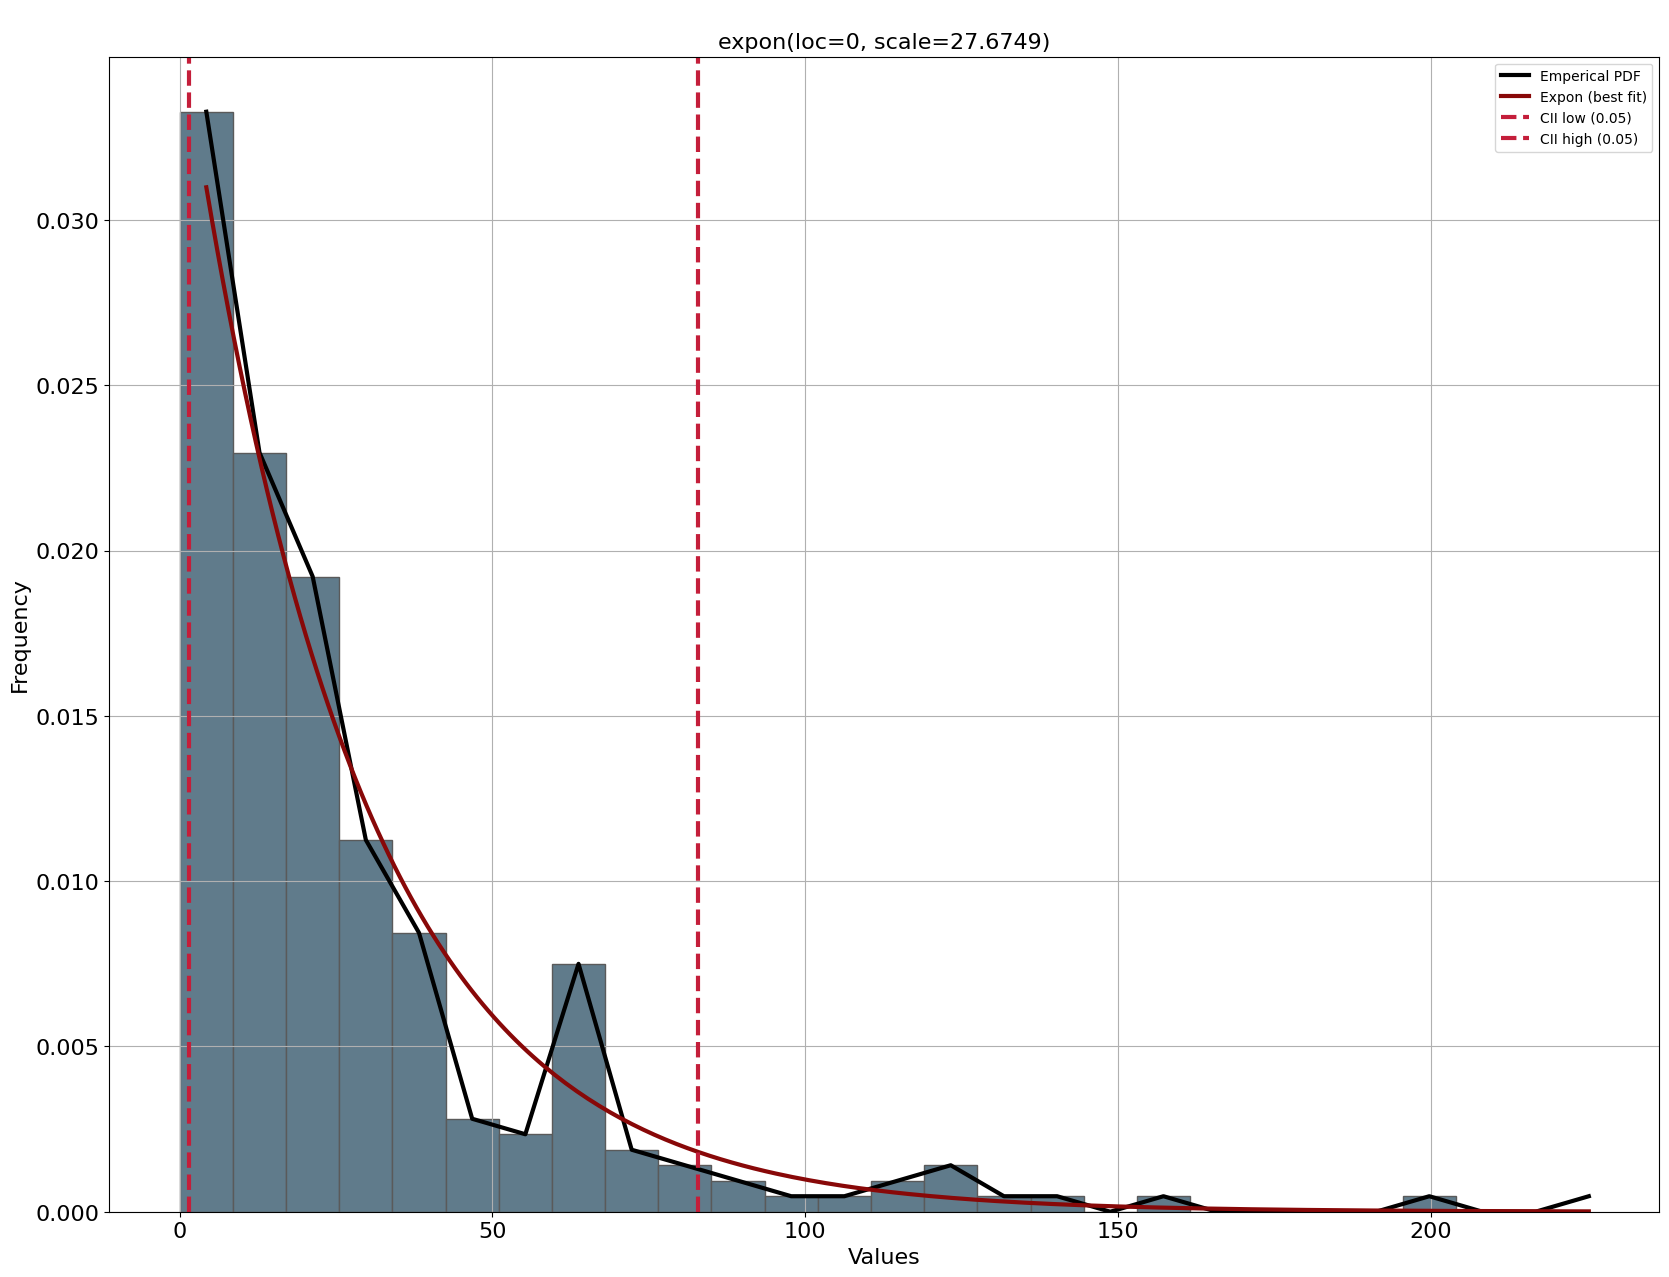

In [7]:
dfit.plot()

## Chi-Square Test

$$ H_0: \text{The sample is exponentially distributed} $$

$$ H_1: \text{The sample is not exponentially distributed} $$

In [8]:
# fitting data to exponential and estimating parameters

loc1, scale1 = ss.expon.fit(arrivals)

### Fit Exponential Distribution with estimated parameters.

rv = ss.expon(loc1,scale1)

### Chi-Square

model(arrivals,100,0)

Power_divergenceResult(statistic=64.83601758207016, pvalue=2.1836101023471424e-05)

# Service

## Graph

In [9]:
service = data["Service Time"]

dfit = distfit(distr = ['expon','erlang', 'gamma'])

dfit.fit_transform(service)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon ] [0.00 sec] [RSS: 0.000589297] [loc=5.970 scale=35.332]
[distfit] >INFO> [erlang] [0.10 sec] [RSS: 7.88516e-05] [loc=5.386 scale=16.879]
[distfit] >INFO> [gamma ] [0.10 sec] [RSS: 0.00273573] [loc=5.970 scale=6.358]
[distfit] >INFO> Compute confidence intervals [parametric]


{'model': {'name': 'erlang',
  'score': 7.88516486484426e-05,
  'loc': 5.385861580359169,
  'scale': 16.87921589450727,
  'arg': (2.127839859434259,),
  'params': (2.127839859434259, 5.385861580359169, 16.87921589450727),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2830c52a590>,
  'bootstrap_score': 0,
  'bootstrap_pass': None,
  'color': '#e41a1c',
  'CII_min_alpha': 12.269739328734008,
  'CII_max_alpha': 88.93410586283824},
 'summary':      name     score       loc      scale                    arg  \
 0  erlang  0.000079  5.385862  16.879216   (2.127839859434259,)   
 1   expon  0.000589      5.97  35.332151                     ()   
 2   gamma  0.002736      5.97   6.358043  (0.2983287282010668,)   
 
                                               params  \
 0  (2.127839859434259, 5.385861580359169, 16.8792...   
 1                          (5.97, 35.33215139442231)   
 2  (0.2983287282010668, 5.969999999999999, 6.3580...   
 
                           

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Erlang(loc:5.385862, scale:16.879216)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nerlang(a=2.12784, loc=5.38586, scale=16.8792)'}, xlabel='Values', ylabel='Frequency'>)

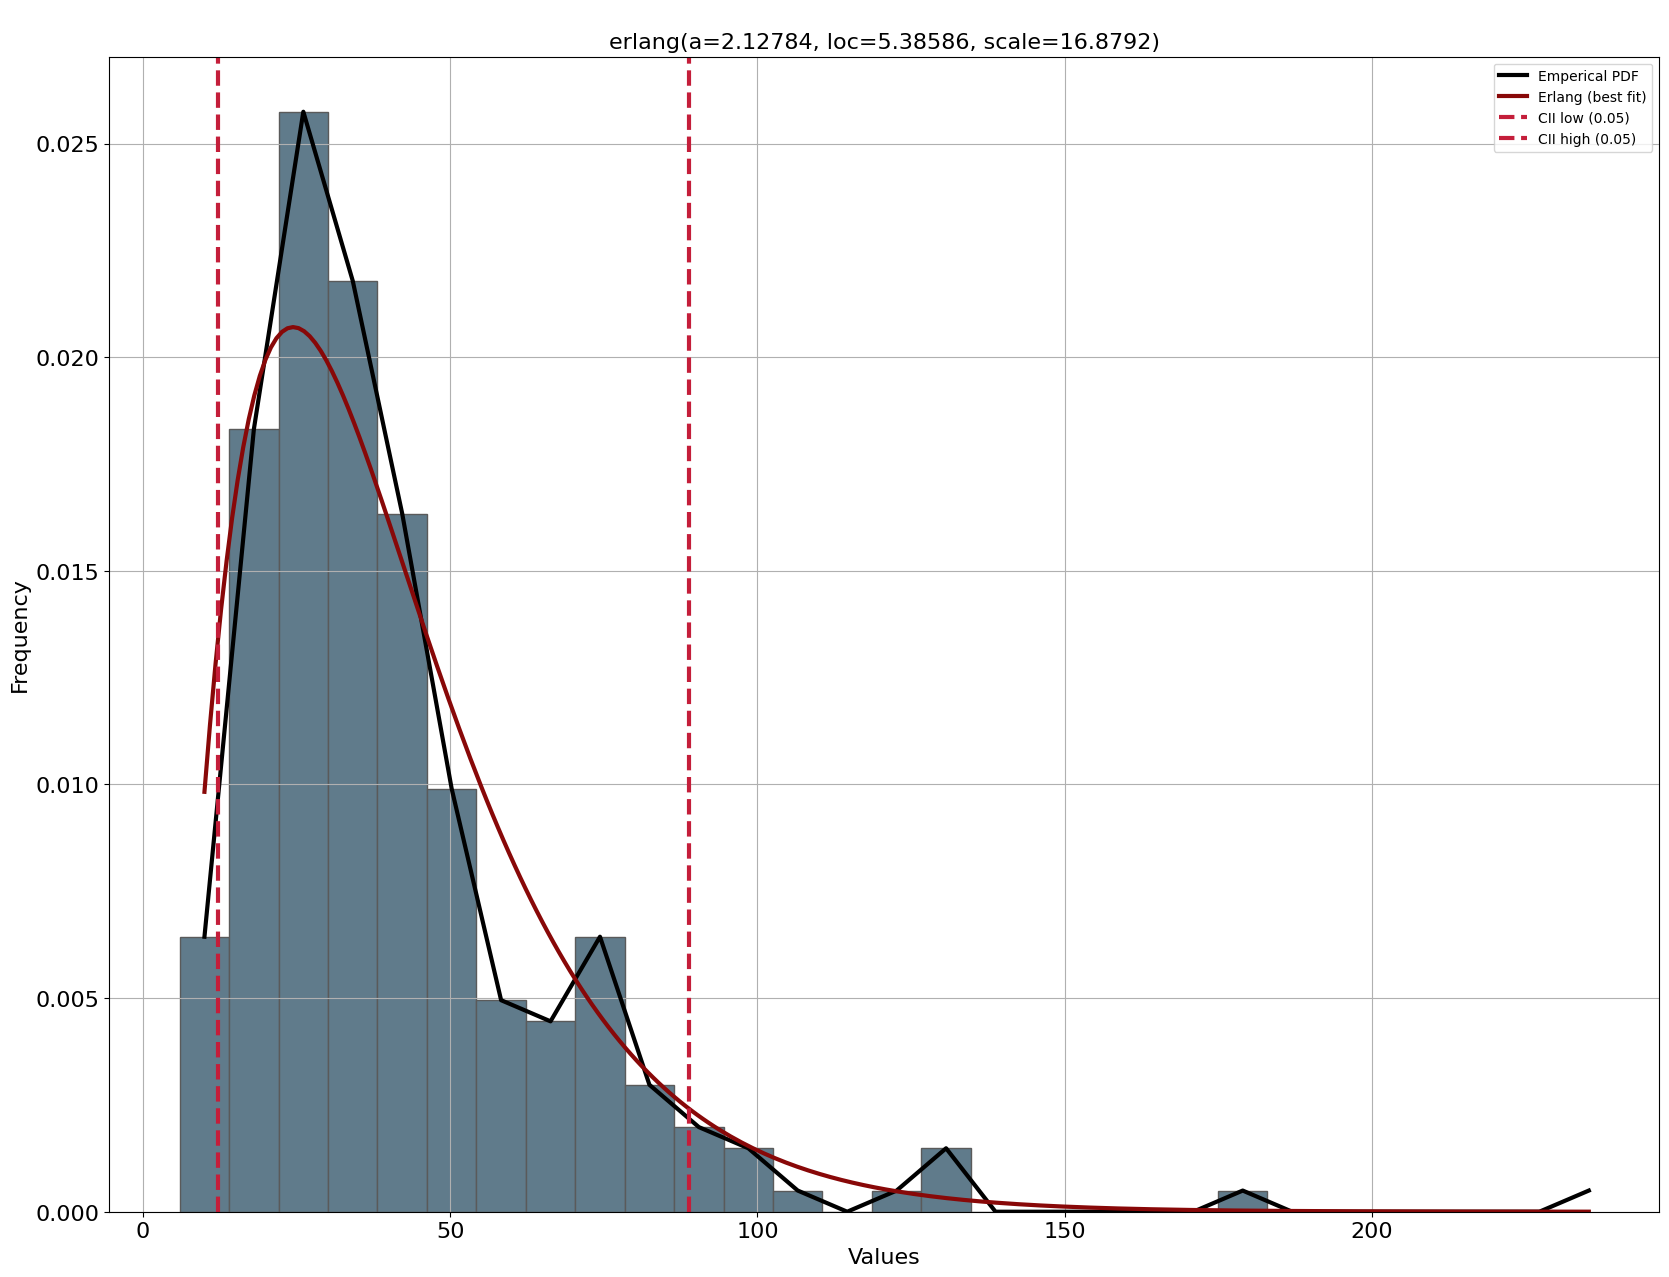

In [10]:
dfit.plot()

## Chi-Square

- H0: The sample is erlang distributed
- H1: The sample is not erland distributed

In [11]:
### Parameter fit based on data

fit_k,fit_loc,fit_beta = ss.erlang.fit(service)

### Fit Erlang Distribution with estimated parameters.

rv = ss.erlang(fit_k,fit_loc,fit_beta)

### Chi-Square

model(service,100,0)

Power_divergenceResult(statistic=26.492185948356493, pvalue=0.546009941220496)

## Result

P-value indicates we can accept the null hypothesis that the sample is erlang distributed.